In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [2]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows, fftconvolve
from scipy.io import wavfile
from scipy.special import genlaguerre
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
import seaborn as sns

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

In [3]:
path_base = '/aquila_ssd2/lthomas/Projects/pySTRF_exampledata'
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(path_base, 'all_stims')  # contains the .wav files

# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(path_base,cellDirName, 'conspecific')

# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [10]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


In [12]:
# Lets set up our parameters for the model
respChunkLen = 250 # length of the response chunk to use for training
segmentBuffer = 100 # number before the response chunk to include in the segment
nLaguerre = 15 # number of laguerre functions to use
feature = 'spect_windows' # feature to use for the model
event_types = 'onoff_feature' # event types to use for the model
nPoints = 150 # number of points to use for the model kernel

In [16]:
# Generate the event features for this dataset
from strfpy.calcSegmentedModel import preprocess_srData

# This function goes through each stim/response pair and finds onsets and offsets
# based on derivatives of the stimulus. It then adds event info into the srData dictionary
preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, tdelta=0)


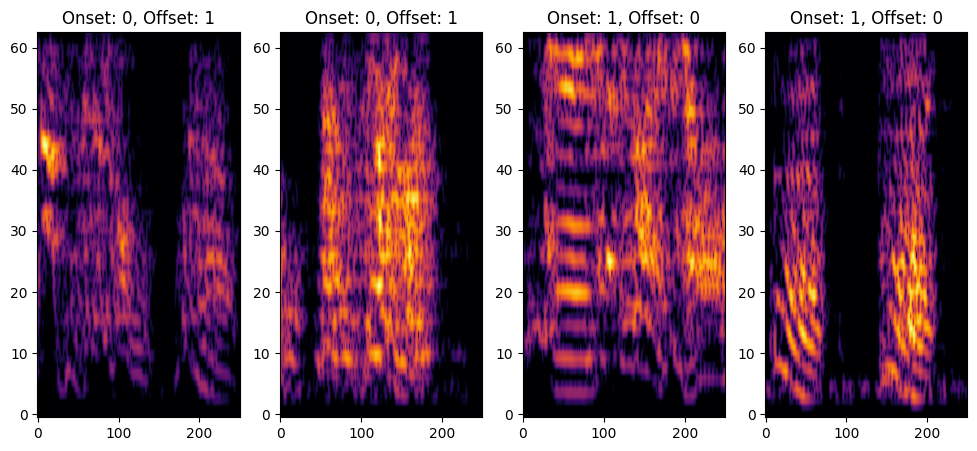

In [30]:
# Lets view some of the spectrograms
fig, ax = plt.subplots(1,4, figsize=(12,5))
for i in range(4):
    rand_idx = np.random.randint(0, len(srData['datasets']))
    specs = srData['datasets'][rand_idx]['events']['spect_windows']
    on_off_feats = srData['datasets'][rand_idx]['events']['onoff_feature']
    rand_ind = np.random.randint(0, len(specs))
    rand_spect = specs[rand_ind]
    ax[i].imshow(rand_spect, aspect='auto', origin='lower', cmap='inferno')
    on_off = on_off_feats[rand_ind]
    ax[i].set_title(f'Onset: {on_off[0]}, Offset: {on_off[1]}')
    # colorbar
    #cbar = ax[i].figure.colorbar(ax[i].imshow(rand_spect, aspect='auto', origin='lower', cmap='inferno'), ax=ax[i])

In [ ]:
# now we can fit the strf model 
# this can be done directly using fit_seg_model, however stepping through this function is advised
# it comes down to three steps:
# 1. Fitting the SEGMENTATION Only Model
# 2. Fitting Laguerre parametesr to the segmentation kernel
# 3. Fitting the full model with the fixed laguerre parameters
from strfpy.calcSegmentedModel import fit_seg_model
